In [1]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 

pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

In [2]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

In [3]:
print(train.shape, test.shape)

(1134555, 9) (537949, 8)


In [4]:
train.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.5120,0.30256,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,1
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.4480,2.13265,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,5
2,a82071a653304481979b5dfb8eb0da47,27,-104.1430,-37.26720,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,4
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.8090,1.31363,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,1
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.3067,15.60110,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,4


In [5]:
test.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id
0,cb3b5c6ea5e441e9b425fc1e6a4a00e6,23,-86.9773,0.268724,6.699850,87.5486,7.39969,63d5670e5c514f00b64c0329382af524
1,838bf5c3f9bc4a2194f51b3c57f403cd,26,72.0487,-7.242040,-0.515331,73.2549,11.06970,8ddc9b4f189d42d08bde2936914341ed
2,fbc245d8b90b4a5d804880e097244a67,6,21.4055,-0.877366,-1.224690,21.6806,3.09542,e9a3a2a70f8f45999a0526c9b7538670
3,f4c5dffa513a443fbbd27ca4c0fbe44f,7,-12.1341,-3.029840,-4.381850,13.3144,1.28673,e8f3cdee49b043a08be537c763e8e2f4
4,74b105d4cb654c4d94da3fb88c8cd6a7,17,133.2230,203.498000,-107.776000,266.3240,12.38630,757c56889e744eff99611d8313ca31f7


In [6]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


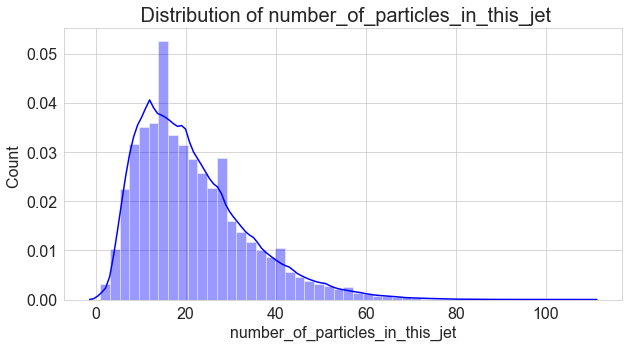

In [7]:
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (10, 5)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()
distplot(train['number_of_particles_in_this_jet'], 'blue')

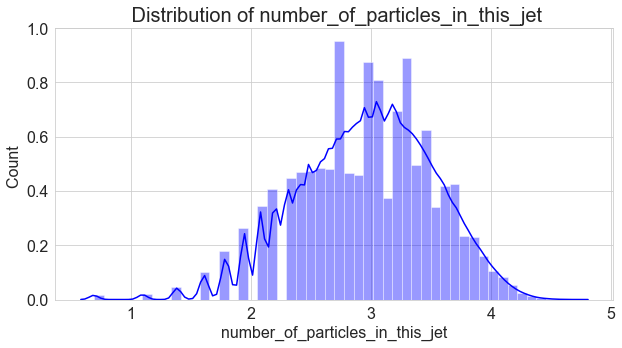

In [8]:

distplot(np.log1p(train['number_of_particles_in_this_jet']), 'blue')


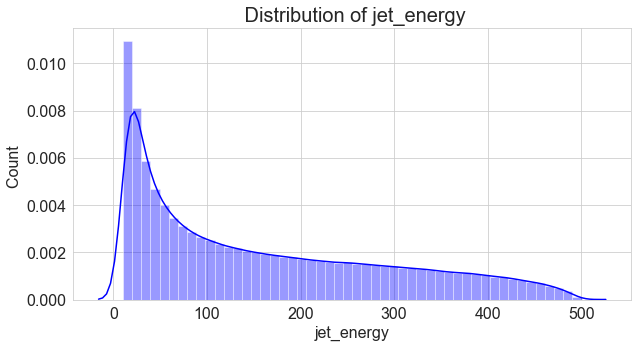

In [9]:
distplot(train['jet_energy'], 'blue')

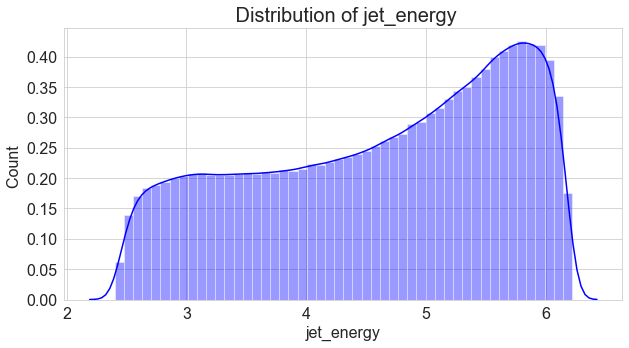

In [10]:
 distplot(np.log1p(train['jet_energy']), 'blue')

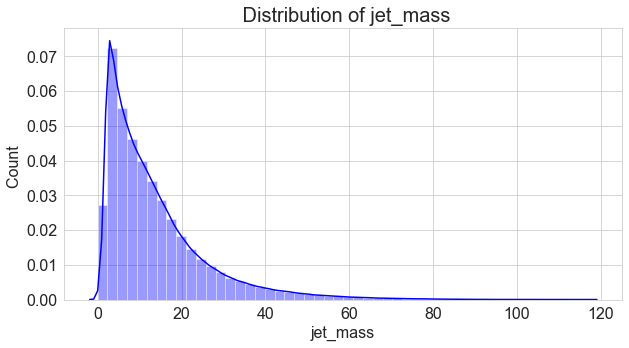

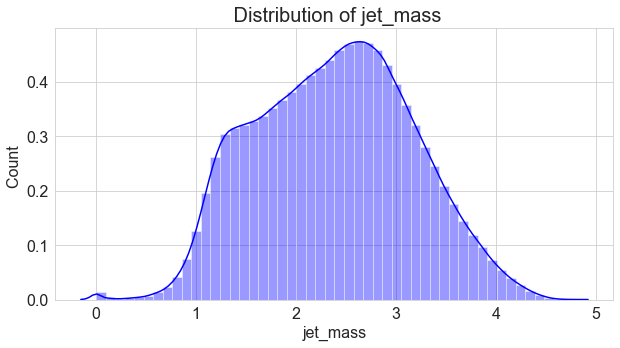

In [11]:
distplot(train['jet_mass'], 'blue')
distplot(np.log1p(train['jet_mass']), 'blue')

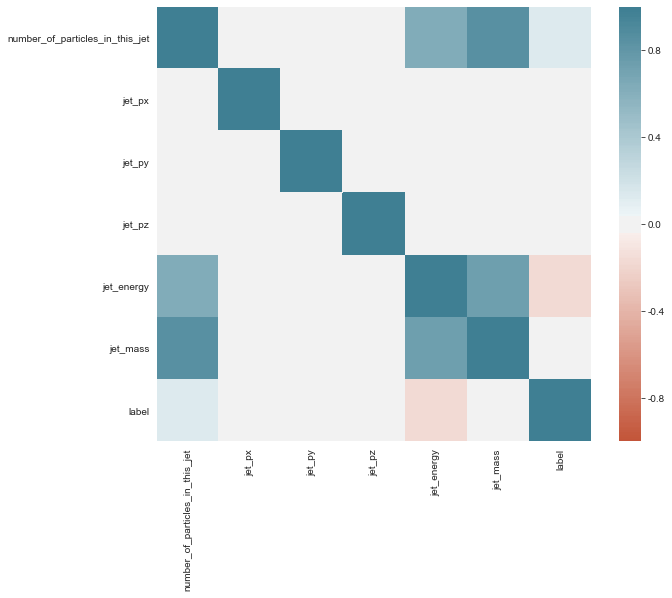

In [12]:
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
object_col = ['label']
for i in tqdm(object_col):
    lbl = LabelEncoder()
    train[i] = lbl.fit_transform(train[i].astype(str))

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [14]:
print(train['label'].value_counts())

1    358600
0    261207
2    260186
3    254562
Name: label, dtype: int64


# 特征工程

In [15]:
# 喷射角度特征

import math
train['xy'] = train['jet_px'] / train['jet_py']
train['tranle_xy'] = train['xy'].map(lambda x : math.atan(x))
train['xz'] = train['jet_px'] /train['jet_pz']
train['tranle_xz'] = train['xz'].map(lambda x : math.atan(x))
train['yz'] = train['jet_py'] /train['jet_pz']
train['tranle_yz'] = train['yz'].map(lambda x : math.atan(x))
train['r'] = (train['jet_px'] * train['jet_px'] + train['jet_py'] * train['jet_py']+ train['jet_pz']* train['jet_pz'])** 0.5
# 每个粒子的能量、质量 、喷注能量比质量
train['particle_energy'] = train['jet_energy'] /train['number_of_particles_in_this_jet']
train['particle_mass'] = train['jet_mass'] /train['number_of_particles_in_this_jet']
train['mass_energy'] = train['jet_energy'] /train['jet_mass']


# test 
test['xy'] = test['jet_px'] / test['jet_py']
test['tranle_xy'] = test['xy'].map(lambda x : math.atan(x))
test['xz'] = test['jet_px'] /test['jet_pz']
test['tranle_xz'] = test['xz'].map(lambda x : math.atan(x))
test['yz'] = test['jet_py'] /test['jet_pz']
test['tranle_yz'] = test['yz'].map(lambda x : math.atan(x))
test['r'] = (test['jet_px'] * test['jet_px'] + test['jet_py'] * test['jet_py']+ test['jet_pz']* test['jet_pz'])** 0.5
# 每个粒子的能量、质量 、喷注能量比质量
test['particle_energy'] = test['jet_energy'] /test['number_of_particles_in_this_jet']
test['particle_mass'] = test['jet_mass'] /test['number_of_particles_in_this_jet']
test['mass_energy'] = test['jet_energy'] /test['jet_mass']


In [16]:
train.head(20)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label,xy,tranle_xy,xz,tranle_xz,yz,tranle_yz,r,particle_energy,particle_mass,mass_energy
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.51200,0.302560,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,0,-953.569540,-1.569748,-156.832389,-1.564420,0.164469,0.163009,288.518024,13.765048,0.846719,16.256924
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.44800,2.132650,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,3,-74.296298,-1.557338,9.730646,1.468388,-0.130971,-0.130230,159.296786,6.143000,0.445569,13.786859
2,a82071a653304481979b5dfb8eb0da47,27,-104.14300,-37.267200,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,2,2.794495,1.227149,5.041169,1.374972,1.803964,1.064631,112.522808,4.197037,0.497100,8.443044
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.80900,1.313630,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,0,216.810670,1.566184,506.485585,1.568822,2.336073,1.166329,284.812585,16.827176,1.571200,10.709761
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.30670,15.601100,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,2,-2.455385,-1.184040,5.052521,1.375401,-2.057731,-1.118434,42.050919,3.516725,0.295952,11.882768
5,b4ca1bcf4b9c4aedbb500f21adb398a8,33,-277.75100,-17.075500,-51.440200,283.2630,12.44620,fce3d18f6c6841fe9715909f6aac3ef1,2,16.266054,1.509396,5.399493,1.387669,0.331949,0.320504,282.989902,8.583727,0.377158,22.758995
6,8440698de493402c987a6eb4dec04fbb,7,6.81748,9.607290,12.590500,17.3225,1.66464,1dec0f8b271b48db818cd42906897e87,1,0.709615,0.617150,0.541478,0.496277,0.763059,0.651806,17.242353,2.474643,0.237806,10.406154
7,927925b32db84240861b7e6bb2ff2f0b,15,249.66200,0.884765,1.114080,250.0910,14.57460,50d011feb97d43c9b5eb99d49a14d016,0,282.178884,1.567252,224.097013,1.566334,0.794166,0.671174,249.666053,16.672733,0.971640,17.159373
8,625710d07b7b4e7780f51766c2f4da50,32,-354.18200,-17.528200,-12.137400,356.5820,35.38130,c2e82ff9287041248290c1f721b96c68,0,20.206410,1.521347,29.181044,1.536541,1.444148,0.965156,354.823116,11.143187,1.105666,10.078262
9,d032bb93386d4ecdac77ec7bdd6bcda2,18,316.81000,0.003403,-2.918050,317.0110,10.90910,877e7da50a9940338f3abac2c9f710f5,3,93104.654204,1.570786,-108.569079,-1.561586,-0.001166,-0.001166,316.823438,17.611722,0.606061,29.059317


In [17]:
print(train.shape, test.shape)

(1134555, 19) (537949, 18)


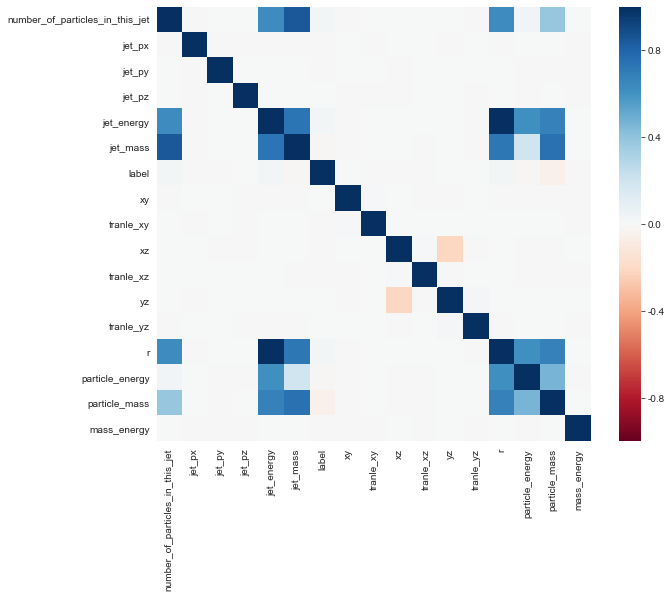

In [18]:
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, 
            square=True, cmap='RdBu') #cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

# 模型训练

In [ ]:
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy',
                  'tranle_xy', 'xz','tranle_xz', 'yz','tranle_yz',
                  'r','particle_energy','particle_mass', 'mass_energy']


from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
#             'metric': {'multi_logloss'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.1,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1, 
            'num_class': 4
            }

folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))
# test_pred = []
# test_pred

for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print(index)
    
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
    lgb_model = lgb.train(params, 
                    train_set = lgb.Dataset(train_x[train_features], train_y), 
                    valid_sets = [lgb.Dataset(train_x[train_features], train_y), 
                                  lgb.Dataset(test_x[train_features],test_y)],
                    num_boost_round=400, 
                    verbose_eval=50, 
                    early_stopping_rounds=50
        )
    y_pred = lgb_model.predict(test_x[train_features], num_iteration=lgb_model.best_iteration)

# #     y_pred = np.argmax(y_pred, axis=1)
#     print(y_pred)
#     print( "分类准确率",  accuracy_score(test_y , y_pred))
#     print('宏平均准确率：',precision_score(test_y , y_pred,average='macro'))
#     print('微平均准确率：',precision_score(test_y , y_pred,average='micro'))
#     print('分类报告：\n',classification_report(test_y , y_pred))

    y_pred_labl_bin = label_binarize(test_y, classes=[0,1,2,3])
    print("auc: ", roc_auc_score(y_pred_labl_bin, y_pred, average='micro'))
    y_pred = np.argmax(y_pred, axis=1)
    print('分类报告：\n',classification_report(test_y , y_pred))
    
    # 交叉验证单模型中，预测测试数据
    test_pre = lgb_model.predict(test[train_features], num_iteration=lgb_model.best_iteration)     
    test_pred += test_pre

    

In [ ]:
test_pred

In [ ]:
pred = np.argmax(test_pred, axis=1)

pred

# 输出特征重要性

In [ ]:

bold("**lightgbm特征重要性**")
# from lightgbm import feature_importances_ 
print(lgb_model.feature_importance())
plt.bar(range(len(lgb_model.feature_importance())), lgb_model.feature_importance())
plt.show()
feature_important = dict(zip(train_features, lgb_model.feature_importance()))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("lgb_model特征重要性:", feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n lgb_model特征 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

In [ ]:
cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x] for x in pred]

In [ ]:
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('baseline-1213.csv', index=False)

# 提交结果：0.59300454342218

In [ ]:
# 将3个tangle特征去掉
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy', 'xz','yz',
                  'r','particle_energy','particle_mass', 'mass_energy']


from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
#             'metric': {'multi_logloss'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.1,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1, 
            'num_class': 4
            }

folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))
# test_pred = []
# test_pred

for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print(index)
    
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
    lgb_model = lgb.train(params, 
                    train_set = lgb.Dataset(train_x[train_features], train_y), 
                    valid_sets = [lgb.Dataset(train_x[train_features], train_y), 
                                  lgb.Dataset(test_x[train_features],test_y)],
                    num_boost_round=400, 
                    verbose_eval=50, 
                    early_stopping_rounds=50
        )
    y_pred = lgb_model.predict(test_x[train_features], num_iteration=lgb_model.best_iteration)

# #     y_pred = np.argmax(y_pred, axis=1)
#     print(y_pred)
#     print( "分类准确率",  accuracy_score(test_y , y_pred))
#     print('宏平均准确率：',precision_score(test_y , y_pred,average='macro'))
#     print('微平均准确率：',precision_score(test_y , y_pred,average='micro'))
#     print('分类报告：\n',classification_report(test_y , y_pred))

    y_pred_labl_bin = label_binarize(test_y, classes=[0,1,2,3])
    print("auc: ", roc_auc_score(y_pred_labl_bin, y_pred, average='micro'))
    y_pred = np.argmax(y_pred, axis=1)
    print('分类报告：\n',classification_report(test_y , y_pred))
    
    # 交叉验证单模型中，预测测试数据
    test_pre = lgb_model.predict(test[train_features], num_iteration=lgb_model.best_iteration)     
    test_pred += test_pre


In [ ]:
pred = np.argmax(test_pred, axis=1)

bold("**lightgbm特征重要性**")
# from lightgbm import feature_importances_ 
print(lgb_model.feature_importance())
plt.bar(range(len(lgb_model.feature_importance())), lgb_model.feature_importance())
plt.show()
feature_important = dict(zip(train_features, lgb_model.feature_importance()))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("lgb_model特征重要性:", feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n lgb_model特征 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)
cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x] for x in pred]

submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('baseline-1213-02.csv', index=False)


# 使用catboost训练

In [30]:
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy',
                  'tranle_xy', 'xz','tranle_xz', 'yz','tranle_yz',
                  'r','particle_energy','particle_mass', 'mass_energy']
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 2
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))

# for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
#     print(index)
    
#     train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
train_x, test_x, train_y, test_y = train_test_split(train, train['label'], test_size=0.33, random_state=42)
model = CatBoostClassifier(
    iterations=1500 ,
    loss_function='MultiClass',
    eval_metric = 'AUC',
    verbose=100,
    learning_rate=0.1, 
    max_depth=5, 
    early_stopping_rounds=50, 
)
model.fit(train_x[train_features], train_y, eval_set=(test_x[train_features], test_y))

y_pred = model.predict(test_x[train_features])
#     print(y_pred.shape)
#     y_pred =y_pred.reshape(test_y.shape)
#     print(y_pred)
#     print(test_y)
#     print(y_pred)
#     y_pred_labl_bin = label_binarize(test_y, classes=[0,1,2,3])
#     print("auc: ", roc_auc_score(test_y, y_pred))
#     y_pred = np.argmax(y_pred, axis=1)
print('分类报告：\n',classification_report(test_y , y_pred))
      # 交叉验证单模型中，预测测试数据
test_pre = model.predict(test[train_features])
# print(test_pre)
#     test_pred += test_pre
    

0:	test: 0.6369867	best: 0.6369867 (0)	total: 224ms	remaining: 5m 35s
100:	test: 0.6799461	best: 0.6799461 (100)	total: 21.1s	remaining: 4m 52s
200:	test: 0.6822043	best: 0.6822043 (200)	total: 42.4s	remaining: 4m 34s
300:	test: 0.6829335	best: 0.6829338 (299)	total: 1m 3s	remaining: 4m 13s
400:	test: 0.6832067	best: 0.6832067 (400)	total: 1m 24s	remaining: 3m 51s
500:	test: 0.6833509	best: 0.6833509 (500)	total: 1m 44s	remaining: 3m 28s
600:	test: 0.6833889	best: 0.6833903 (598)	total: 2m 4s	remaining: 3m 6s
700:	test: 0.6834040	best: 0.6834331 (660)	total: 2m 24s	remaining: 2m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6834331398
bestIteration = 660

Shrink model to first 661 iterations.
分类报告：
               precision    recall  f1-score   support

           0       0.40      0.33      0.36     86315
           1       0.46      0.86      0.60    118415
           2       0.35      0.14      0.20     85509
           3       0.40      0.22      0.28     

In [ ]:
cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x[0]] for x in test_pre]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1214.csv', index=False)
# 0.59360 
#目前看 模型上没啥创新了，关键还是特征


#  特征工程2

In [19]:
train.columns

Index(['jet_id', 'number_of_particles_in_this_jet', 'jet_px', 'jet_py',
       'jet_pz', 'jet_energy', 'jet_mass', 'event_id', 'label', 'xy',
       'tranle_xy', 'xz', 'tranle_xz', 'yz', 'tranle_yz', 'r',
       'particle_energy', 'particle_mass', 'mass_energy'],
      dtype='object')

In [20]:
train.head(5)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label,xy,tranle_xy,xz,tranle_xz,yz,tranle_yz,r,particle_energy,particle_mass,mass_energy
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.5120,0.30256,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,0,-953.569540,-1.569748,-156.832389,-1.564420,0.164469,0.163009,288.518024,13.765048,0.846719,16.256924
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.4480,2.13265,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,3,-74.296298,-1.557338,9.730646,1.468388,-0.130971,-0.130230,159.296786,6.143000,0.445569,13.786859
2,a82071a653304481979b5dfb8eb0da47,27,-104.1430,-37.26720,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,2,2.794495,1.227149,5.041169,1.374972,1.803964,1.064631,112.522808,4.197037,0.497100,8.443044
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.8090,1.31363,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,0,216.810670,1.566184,506.485585,1.568822,2.336073,1.166329,284.812585,16.827176,1.571200,10.709761
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.3067,15.60110,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,2,-2.455385,-1.184040,5.052521,1.375401,-2.057731,-1.118434,42.050919,3.516725,0.295952,11.882768


In [21]:
train_new = train.copy()
test_new = test.copy()

In [22]:
# 求每个事件对应的喷注数量

jet_id_map ={}
event_id_map ={}

with open('./jet_simple_data/simple_train_R04_jet.csv') as train:
    count =0
    for line in train:
        count += 1
        if count == 1 : continue
        
        line_arr = line.strip().split(",")
        if (line_arr[0] in jet_id_map):
            jet_id_map[line_arr[0]] += 1
        else:
            jet_id_map[line_arr[0]] =1

        if (line_arr[7] in event_id_map):
            event_id_map[line_arr[7]] += 1
        else:
            event_id_map[line_arr[7]] =1

with open('./jet_simple_data/simple_test_R04_jet.csv') as train:
    count =0
    for line in train:
        count += 1
        if count == 1 : continue
        
        line_arr = line.strip().split(",")
        if (line_arr[0] in jet_id_map):
            jet_id_map[line_arr[0]] += 1
        else:
            jet_id_map[line_arr[0]] =1

        if (line_arr[7] in event_id_map):
            event_id_map[line_arr[7]] += 1
        else:
            event_id_map[line_arr[7]] =1
print(len(jet_id_map), len(event_id_map))

1672504 548097


In [23]:
train_new['event_id_num'] = train_new['event_id'].map(lambda x: event_id_map[x])
test_new['event_id_num'] = test_new['event_id'].map(lambda x: event_id_map[x])

In [24]:
train =train_new
test =test_new

In [25]:
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy',
                  'tranle_xy', 'xz','tranle_xz', 'yz','tranle_yz',
                  'r','particle_energy','particle_mass', 'mass_energy', 'event_id_num']
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 2
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))

# for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
#     print(index)
    
#     train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
train_x, test_x, train_y, test_y = train_test_split(train, train['label'], test_size=0.33, random_state=42)
model = CatBoostClassifier(
    iterations=1500 ,
    loss_function='MultiClass',
    eval_metric = 'AUC',
    verbose=100,
    learning_rate=0.1, 
    max_depth=6, 
    early_stopping_rounds=50, 
)
model.fit(train_x[train_features], train_y, eval_set=(test_x[train_features], test_y))

y_pred = model.predict(test_x[train_features])
#     print(y_pred.shape)
#     y_pred =y_pred.reshape(test_y.shape)
#     print(y_pred)
#     print(test_y)
#     print(y_pred)
#     y_pred_labl_bin = label_binarize(test_y, classes=[0,1,2,3])
#     print("auc: ", roc_auc_score(test_y, y_pred))
#     y_pred = np.argmax(y_pred, axis=1)
print('分类报告：\n',classification_report(test_y , y_pred))
      # 交叉验证单模型中，预测测试数据
test_pre = model.predict(test[train_features])
# print(test_pre)

cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x[0]] for x in test_pre]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1214-02.csv', index=False)
# 0.59360 ==> 0.604643293649761
# 目前看这个特征有用的，效果有提升，event_id_num

0:	test: 0.6704395	best: 0.6704395 (0)	total: 436ms	remaining: 10m 53s
100:	test: 0.7043224	best: 0.7043224 (100)	total: 24.4s	remaining: 5m 38s
200:	test: 0.7061149	best: 0.7061186 (199)	total: 47.7s	remaining: 5m 8s
300:	test: 0.7066552	best: 0.7066552 (300)	total: 1m 11s	remaining: 4m 45s
400:	test: 0.7067304	best: 0.7067353 (393)	total: 1m 34s	remaining: 4m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7067762795
bestIteration = 444

Shrink model to first 445 iterations.
分类报告：
               precision    recall  f1-score   support

           0       0.39      0.36      0.37     86315
           1       0.50      0.83      0.62    118415
           2       0.33      0.17      0.22     85509
           3       0.39      0.26      0.31     84165

    accuracy                           0.44    374404
   macro avg       0.40      0.40      0.38    374404
weighted avg       0.41      0.44      0.40    374404



#  特征工程3

In [26]:
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy',
                   'xz', 'yz', 'tranle_xy','tranle_xz', 'tranle_yz',
                  'r','particle_energy','particle_mass', 'mass_energy', 'event_id_num']

train['particle_x'] = train['number_of_particles_in_this_jet'] / train['jet_px']
train['particle_y'] = train['number_of_particles_in_this_jet'] / train['jet_py']
train['particle_z'] = train['number_of_particles_in_this_jet'] / train['jet_pz']

train['xr'] = train['jet_px'] / train['r'] 
train['yr'] = train['jet_py'] / train['r'] 
train['zr'] = train['jet_pz'] / train['r'] 

train['mass_x'] = train['jet_mass'] / train['jet_px']
train['mass_y'] = train['jet_mass'] / train['jet_py']
train['mass_z'] = train['jet_mass'] / train['jet_pz']

train['energy_x'] = train['jet_energy'] / train['jet_px']
train['energy_y'] = train['jet_energy'] / train['jet_py']
train['energy_z'] = train['jet_energy'] / train['jet_pz']
train['energy_event'] = train['jet_energy'] / train['event_id_num']
train['mass_event'] = train['jet_mass'] / train['event_id_num']

train['particle_x'] =test['number_of_particles_in_this_jet'] /test['jet_px']
train['particle_y'] =test['number_of_particles_in_this_jet'] /test['jet_py']
train['particle_z'] =test['number_of_particles_in_this_jet'] /test['jet_pz']

train['xr'] =test['jet_px'] /test['r'] 
train['yr'] =test['jet_py'] /test['r'] 
train['zr'] =test['jet_pz'] /test['r'] 

train['mass_x'] =test['jet_mass'] /test['jet_px']
train['mass_y'] =test['jet_mass'] /test['jet_py']
train['mass_z'] =test['jet_mass'] /test['jet_pz']

train['energy_x'] =test['jet_energy'] /test['jet_px']
train['energy_y'] =test['jet_energy'] /test['jet_py']
train['energy_z'] =test['jet_energy'] /test['jet_pz']
train['energy_event'] =test['jet_energy'] /test['event_id_num']
train['mass_event'] =test['jet_mass'] /test['event_id_num']
train['particle_event'] =train['number_of_particles_in_this_jet'] /train['event_id_num']


test['particle_x'] = test['number_of_particles_in_this_jet'] / test['jet_px']
test['particle_y'] = test['number_of_particles_in_this_jet'] / test['jet_py']
test['particle_z'] = test['number_of_particles_in_this_jet'] / test['jet_pz']

test['xr'] = test['jet_px'] / test['r'] 
test['yr'] = test['jet_py'] / test['r'] 
test['zr'] = test['jet_pz'] / test['r'] 

test['mass_x'] = test['jet_mass'] / test['jet_px']
test['mass_y'] = test['jet_mass'] / test['jet_py']
test['mass_z'] = test['jet_mass'] / test['jet_pz']

test['energy_x'] = test['jet_energy'] / test['jet_px']
test['energy_y'] = test['jet_energy'] / test['jet_py']
test['energy_z'] = test['jet_energy'] / test['jet_pz']
test['energy_event'] = test['jet_energy'] / test['event_id_num']
test['mass_event'] = test['jet_mass'] / test['event_id_num']

test['particle_x'] =test['number_of_particles_in_this_jet'] /test['jet_px']
test['particle_y'] =test['number_of_particles_in_this_jet'] /test['jet_py']
test['particle_z'] =test['number_of_particles_in_this_jet'] /test['jet_pz']

test['xr'] =test['jet_px'] /test['r'] 
test['yr'] =test['jet_py'] /test['r'] 
test['zr'] =test['jet_pz'] /test['r'] 

test['mass_x'] =test['jet_mass'] /test['jet_px']
test['mass_y'] =test['jet_mass'] /test['jet_py']
test['mass_z'] =test['jet_mass'] /test['jet_pz']

test['energy_x'] =test['jet_energy'] /test['jet_px']
test['energy_y'] =test['jet_energy'] /test['jet_py']
test['energy_z'] =test['jet_energy'] /test['jet_pz']
test['energy_event'] =test['jet_energy'] /test['event_id_num']
test['mass_event'] =test['jet_mass'] /test['event_id_num']
test['particle_event'] =test['number_of_particles_in_this_jet'] /test['event_id_num']

In [27]:
train.columns

Index(['jet_id', 'number_of_particles_in_this_jet', 'jet_px', 'jet_py',
       'jet_pz', 'jet_energy', 'jet_mass', 'event_id', 'label', 'xy',
       'tranle_xy', 'xz', 'tranle_xz', 'yz', 'tranle_yz', 'r',
       'particle_energy', 'particle_mass', 'mass_energy', 'event_id_num',
       'particle_x', 'particle_y', 'particle_z', 'xr', 'yr', 'zr', 'mass_x',
       'mass_y', 'mass_z', 'energy_x', 'energy_y', 'energy_z', 'energy_event',
       'mass_event', 'particle_event'],
      dtype='object')

In [28]:
print(train_features)

train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass','xy',
                   'xz', 'yz', 'tranle_xy','tranle_xz', 'tranle_yz',
                  'r','particle_energy','particle_mass', 'mass_energy', 
                  'event_id_num', 'particle_x','particle_y','particle_z', 
                  'xr', 'yr', 'zr', 'mass_x','mass_y', 'mass_z', 'energy_x', 
                  'energy_y','energy_z','energy_event','mass_event','particle_event']# bestTest = 0.7068003603

# train_features = ['number_of_particles_in_this_jet','jet_px', 
#                   'jet_py', 'jet_pz', 'jet_energy', 'jet_mass',
#                   'particle_energy','particle_mass', 'mass_energy', 
#                   'event_id_num'] #bestTest = 0.7071510358

train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy', 'jet_mass',
                  'particle_energy','particle_mass', 'mass_energy', 
                  'event_id_num', 'particle_event'] # bestTest = 0.7071216899

# depth=5 0.706968877
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 2
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))

# for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
#     print(index)
    
#     train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
train_x, test_x, train_y, test_y = train_test_split(train, train['label'], test_size=0.33, random_state=42)
model = CatBoostClassifier(
    iterations=1500 ,
    loss_function='MultiClass',
    custom_metric= 'AUC',
    eval_metric = 'AUC',
    verbose=100,
    learning_rate=0.05, 
    max_depth=6, 
    early_stopping_rounds=50, 
)
model.fit(train_x[train_features], train_y, eval_set=(test_x[train_features], test_y))

y_pred = model.predict(test_x[train_features])

print('分类报告：\n',classification_report(test_y , y_pred))
      # 交叉验证单模型中，预测测试数据
test_pre = model.predict(test[train_features])
# print(test_pre)

cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x[0]] for x in test_pre]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1214-03.csv', index=False)

['number_of_particles_in_this_jet', 'jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_mass', 'xy', 'xz', 'yz', 'tranle_xy', 'tranle_xz', 'tranle_yz', 'r', 'particle_energy', 'particle_mass', 'mass_energy', 'event_id_num']
0:	test: 0.6732218	best: 0.6732218 (0)	total: 237ms	remaining: 5m 55s
100:	test: 0.7022798	best: 0.7022798 (100)	total: 23s	remaining: 5m 19s
200:	test: 0.7048089	best: 0.7048089 (200)	total: 44.9s	remaining: 4m 49s
300:	test: 0.7059318	best: 0.7059318 (300)	total: 1m 7s	remaining: 4m 27s
400:	test: 0.7065012	best: 0.7065012 (400)	total: 1m 29s	remaining: 4m 5s
500:	test: 0.7068269	best: 0.7068286 (499)	total: 1m 51s	remaining: 3m 41s
600:	test: 0.7069660	best: 0.7069660 (600)	total: 2m 12s	remaining: 3m 18s
700:	test: 0.7070905	best: 0.7070907 (698)	total: 2m 34s	remaining: 2m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7071216899
bestIteration = 744

Shrink model to first 745 iterations.
分类报告：
               precision    recall  f1-score  

**catboost特征重要性**

[14.51910951  0.77419403  6.25476438  7.91660224  1.39469101  2.87921828
 13.79223274  8.25926259 13.25012265 26.70043307  4.25936951]
[('event_id_num', 26.70043306605039), ('number_of_particles_in_this_jet', 14.519109507919076), ('particle_energy', 13.792232739965362), ('mass_energy', 13.25012265264233), ('particle_mass', 8.259262592027278), ('jet_pz', 7.916602235086222), ('jet_py', 6.254764382820565), ('particle_event', 4.259369506772119), ('jet_mass', 2.8792182764454375), ('jet_energy', 1.3946910142395803), ('jet_px', 0.7741940260316283)]


 catboost 重要性 > 0 特征类别： 11 ['event_id_num', 'number_of_particles_in_this_jet', 'particle_energy', 'mass_energy', 'particle_mass', 'jet_pz', 'jet_py', 'particle_event', 'jet_mass', 'jet_energy', 'jet_px']


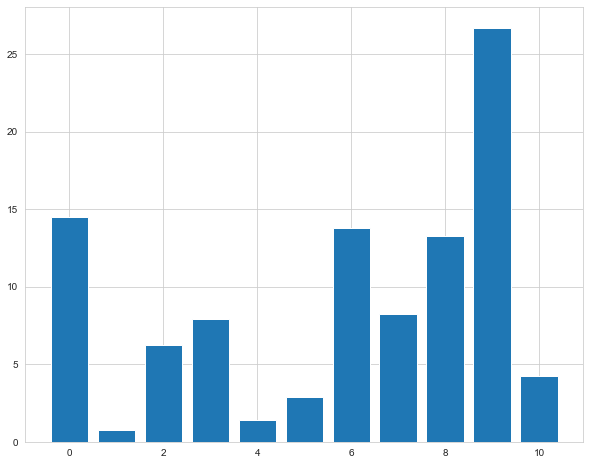

In [29]:
bold("**catboost特征重要性**")
print(model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
feature_important = dict(zip(train_features, model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value >0.0]

print("\n\n catboost 重要性 > 0 特征类别：", len(feature_import_usefull),  feature_import_usefull)



# 特征工程4

In [30]:
train['jet_mass_log1p'] = np.log1p(train['jet_mass'])
train['jet_energy_log1p'] = np.log1p(train['jet_energy'])

test['jet_mass_log1p'] = np.log1p(test['jet_mass'])
test['jet_energy_log1p'] = np.log1p(test['jet_energy'])



import math
# 每个粒子的能量、质量 、喷注能量比质量
train['particle_energy_log1p'] = train['jet_energy_log1p'] /train['number_of_particles_in_this_jet']
train['particle_mass_log1p'] = train['jet_mass_log1p'] /train['number_of_particles_in_this_jet']
train['mass_energy_log1p'] = train['jet_energy_log1p'] /train['jet_mass_log1p']

test['particle_energy_log1p'] = test['jet_energy_log1p'] /test['number_of_particles_in_this_jet']
test['particle_mass_log1p'] = test['jet_mass_log1p'] /test['number_of_particles_in_this_jet']
test['mass_energy_log1p'] = test['jet_energy_log1p'] /test['jet_mass_log1p']



In [31]:
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy_log1p', 'jet_mass_log1p',
                  'particle_energy_log1p','particle_mass_log1p', 'mass_energy_log1p', 
                  'event_id_num', 'particle_event'] # bestTest = 0.7071070533
train_features = ['number_of_particles_in_this_jet','jet_px', 
                  'jet_py', 'jet_pz', 'jet_energy_log1p', 'jet_mass_log1p',
                  'particle_energy_log1p','particle_mass_log1p', 'mass_energy_log1p', 
                  'event_id_num'] # bestTest = 0.7071228958
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 2
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))

# for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
#     print(index)
    
#     train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
train_x, test_x, train_y, test_y = train_test_split(train, train['label'], test_size=0.33, random_state=42)
model = CatBoostClassifier(
    iterations=1500 ,
    loss_function='MultiClass',
    custom_metric= 'AUC',
    eval_metric = 'AUC',
    verbose=100,
    learning_rate=0.05, 
    max_depth=6, 
    early_stopping_rounds=50, 
)
model.fit(train_x[train_features], train_y, eval_set=(test_x[train_features], test_y))

y_pred = model.predict(test_x[train_features])

print('分类报告：\n',classification_report(test_y , y_pred))
      # 交叉验证单模型中，预测测试数据
test_pre = model.predict(test[train_features])
# print(test_pre)

cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x[0]] for x in test_pre]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1214-04.csv', index=False)

0:	test: 0.6662832	best: 0.6662832 (0)	total: 246ms	remaining: 6m 9s
100:	test: 0.7021788	best: 0.7021788 (100)	total: 23.4s	remaining: 5m 24s
200:	test: 0.7048965	best: 0.7048965 (200)	total: 45.4s	remaining: 4m 53s
300:	test: 0.7059909	best: 0.7059909 (300)	total: 1m 7s	remaining: 4m 27s
400:	test: 0.7065323	best: 0.7065323 (400)	total: 1m 29s	remaining: 4m 4s
500:	test: 0.7068436	best: 0.7068436 (500)	total: 1m 51s	remaining: 3m 42s
600:	test: 0.7070085	best: 0.7070085 (600)	total: 2m 14s	remaining: 3m 21s
700:	test: 0.7071026	best: 0.7071100 (687)	total: 2m 36s	remaining: 2m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7071228958
bestIteration = 748

Shrink model to first 749 iterations.
分类报告：
               precision    recall  f1-score   support

           0       0.39      0.37      0.38     86315
           1       0.50      0.83      0.62    118415
           2       0.33      0.16      0.22     85509
           3       0.39      0.25      0.31     